In [180]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
from PIL import Image

In [181]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
#Gpu will be used instead of cpu if available

In [182]:
model = models.vgg19(pretrained = True).features
model.to(device)
#VGG19 architecture
#if you haven't had before, it starts to download

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [183]:
def open_image(path, size=400, shape=None):
    image = Image.open(path).convert('RGB') #open our content image from the path given and gain it in RGB form
    
    #if condition below changes the size of the content image if it had larger size than permitted
    if max(image.size) > size:
        s = size
    else:
        s = max(image.size) #if it was not larger in size than allowed one, it maintains the original size
    
    if shape is not None:
        size = shape
        #content image size = style image size
 
    in_transform = transforms.Compose([
                        transforms.Resize(s),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    image = in_transform(image).unsqueeze(0) #tensor return
    
    return image

In [184]:
#we are allowed to use images in numpy arrays and we should convert them from tensors
def TN_convert(tensor):
    image = tensor.to("cpu").clone().detach() #clone is for copying tensor first and then apply some other functions to it
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)  #this makes our image to transform from 1,28,28 to 28,28,1
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) #as from our equation for normalization
    #this normalization take back our arrays from [0, 1] to [-1, 1]
    image = image.clip(0, 1) #to limit values between 0 and 1

    return image

In [185]:
style_img = open_image('H:/Moein Amin/elham/data/paint.jpg').to(device)
content_img = content_img.detach().to(device)
content_img = open_image('H:/Moein Amin/elham/data/newyork.jpg',shape=content_img.shape[-2:]).to(device) 
style_img = style_img.clone().detach().to(device)
#same size as content image

(-0.5, 532.5, 399.5, -0.5)

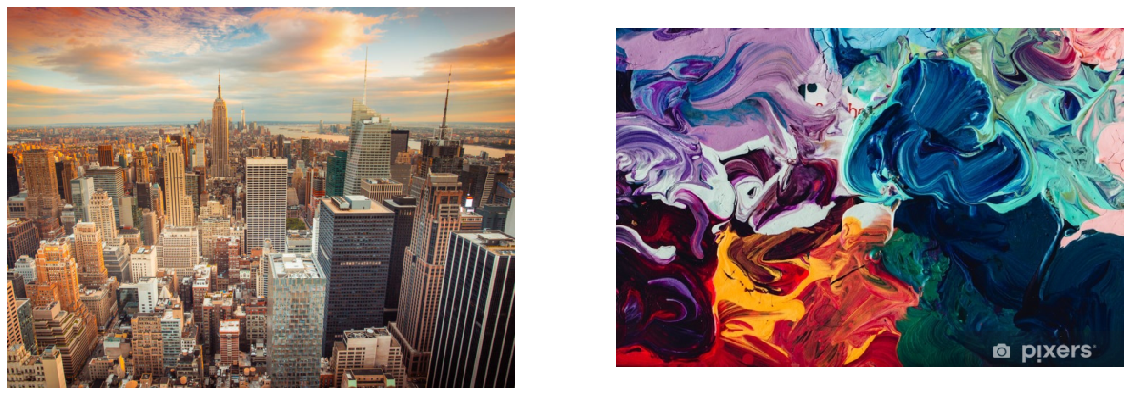

In [186]:
fig, (st, cn) = plt.subplots(1, 2, figsize=(20, 10)) #1 = row, 2 = columns, size = 20*10

cn.imshow(TN_convert(style_img))
cn.axis("off")

st.imshow(TN_convert(content_img))
st.axis("off")

In [187]:
def features(image, model): #obtaining features of both pictures
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',
              '28': 'conv5_1'}
        
    F = {}
    for N, layer in model._modules.items():
        image = layer(image)
        if N in layers:
            F[layers[N]] = image
            
    return F #returning our features

In [188]:
content_img_features = features(content_img, model)
style_img_features = features(style_img, model)

In [189]:
def Gmatrix(temp):
    batch_size, depth, height, weight = temp.size()
    temp = temp.view(depth, height * weight)
    G = torch.mm(temp, temp.t()) #matrix multiplication
    return G

style_grams = {layer: Gmatrix(style_img_features[layer]) for layer in style_img_features}

In [190]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

#alpha and beta
content_img_weight = 1 
style_img_weight = 1e6

final_img = content_img.clone().requires_grad_(True).to(device) #our final image first is initialized with contend image

In [191]:
optimizer = torch.optim.Adam([final_img], lr=0.005) #our optimizer = Adam
height, width, channels = TN_convert(final_img).shape
counter=0
image_array = np.empty(shape=(300, height, width, channels))

show_every = 300 #show target image 



STEP:  0
LOSS:  57979468.0



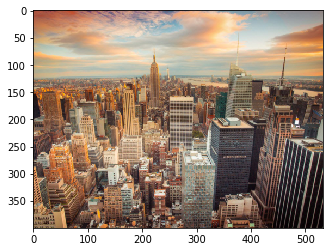

STEP:  200
LOSS:  3411043.5



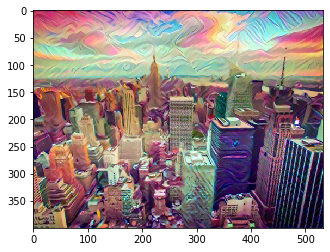

STEP:  400
LOSS:  1095923.5



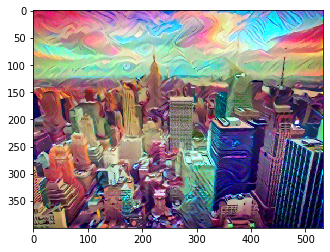

STEP:  600
LOSS:  694798.4375



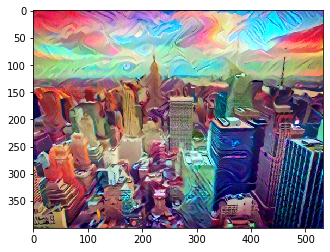

STEP:  800
LOSS:  528128.875



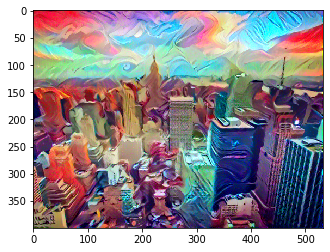

STEP:  1000
LOSS:  424170.46875



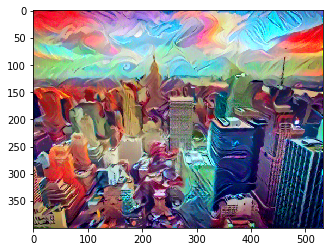

STEP:  1200
LOSS:  354080.96875



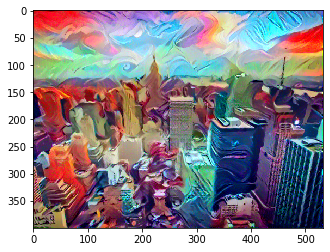

STEP:  1400
LOSS:  304270.78125



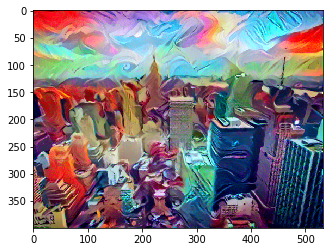

STEP:  1600
LOSS:  267198.25



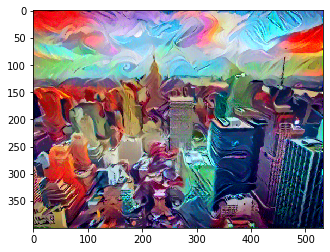

STEP:  1800
LOSS:  238420.6875



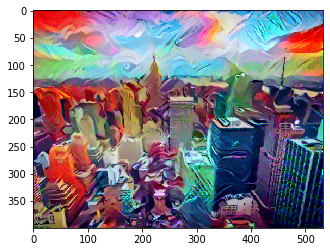

STEP:  2000
LOSS:  215332.59375



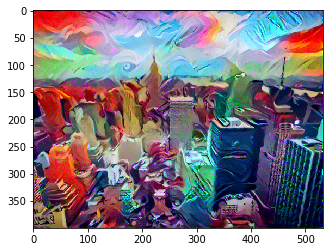

In [192]:
#main process

for j in range(0, 2001):
    final_img_features = features(final_img, model)
    style_img_loss = 0
    #evaluating the loss and difference between 2 pictures: final and the content
    content_img_loss = torch.mean((final_img_features['conv4_2'] - content_img_features['conv4_2'])**2)
    
    
    for layer in style_weights:
        final_img_feature = final_img_features[layer]
        final_img_gram = Gmatrix(final_img_feature)
        style_img_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((final_img_gram - style_img_gram)**2)
        batch, depth, height, weight = final_img_feature.shape
        style_img_loss += layer_style_loss / (depth * height * weight)
  
    total_loss = content_img_weight * content_img_loss + style_img_weight * style_img_loss 
    
    optimizer.zero_grad()
    total_loss.backward(retain_graph=True)
    optimizer.step()
 
    if  j % 200 == 0:
        print('=======================================')
        print('STEP: ', j)
        print('LOSS: ', total_loss.item())
        print('')
        plt.imshow(TN_convert(final_img))
        plt.show()
        